# Examen 0101

## Parámetros

In [1]:
BASE_DIR = '/Users/efraflores/Desktop/EF/Diplo/data/other/DiegoF/01'
FILE_NAME = 'dataset_examen.csv'

## Funciones

### Column vs target

In [2]:
def col_vs_tgt(data, col, target='loan_status'):
    data['grouped'] = data[col]
    vs = data.pivot_table(index='grouped', columns=target, aggfunc={'id':'count'})
    vs = vs/vs.sum()
    return vs.style.format("{:.1%}").background_gradient('Blues')

### Group classes with low frequency

In [3]:
def group_lowfreq(df_col, p=0.05):
    tot_freq = df_col.value_counts(1).to_frame()
    tot_freq['group'] = [col if freq>p else 'other' for col,freq in zip(tot_freq.index,tot_freq.iloc[:,-1])]
    return df_col.map(tot_freq.iloc[:,-1].to_dict())

### Replace top words

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

def replace_top_words(data, col, **kwargs):
    df = data.copy()
    cv = CountVectorizer(**kwargs)
    cv.fit(df[col])

    full = pd.DataFrame(cv.transform(df[col]).toarray(), index=zip(df.index,df[col].str.lower()), columns=cv.get_feature_names())
    full['total'] = full.sum(axis=1)

    replaced = []
    for i, tot in enumerate(full['total']):
        if tot==0: replaced.append('other')
        else:
            transposed = full.iloc[i,:-1].T.to_frame()
            unique_col = transposed.columns[0]
            filtered = transposed[transposed[unique_col]>0].sort_values(unique_col, ascending=False)
            replaced.append(filtered.index[0]) 
    
    return replaced, cv

## Importar

In [5]:
import pandas as pd
from pathlib import Path

BASE_DIR = Path(BASE_DIR)
df = pd.read_csv(BASE_DIR.joinpath(FILE_NAME), low_memory=False)
print(df.shape)
df.head()

(887379, 74)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Transformar

### Sólo dos estatus de préstamo

In [6]:
df['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [7]:
df = df[df['loan_status'].isin(['Fully Paid','Charged Off'])]
df['loan_status'].value_counts(1)

Fully Paid     0.821134
Charged Off    0.178866
Name: loan_status, dtype: float64

### Por variable

In [8]:
vars_date = []
vars_cat = []
vars_bin = []
vars_num = []
df_replace = {}
df_bins = {}
count_v = {}

#### 1.	acc now delinq: El número de cuentas en las que el prestatario está ahora en mora

In [9]:
df['acc_now_delinq'].value_counts(dropna=False)

0.0    252236
1.0       693
2.0        36
3.0         3
5.0         2
4.0         1
Name: acc_now_delinq, dtype: int64

In [10]:
df['acc_now_delinq'] = (df['acc_now_delinq'] > 0)*1
df['acc_now_delinq'].value_counts(1, dropna=False)

0    0.997095
1    0.002905
Name: acc_now_delinq, dtype: float64

In [11]:
vars_bin.append('acc_now_delinq')
col_vs_tgt(df,'acc_now_delinq')

#### 2.	addr state: El estado proporcionado por el prestatario en la solicitud de préstamo

In [12]:
df['addr_state'].value_counts(1, dropna=False)

CA    0.170415
NY    0.084350
TX    0.076463
FL    0.069356
NJ    0.037953
IL    0.036577
PA    0.033201
GA    0.031680
VA    0.031395
OH    0.030588
NC    0.027351
MA    0.024268
AZ    0.024023
MD    0.023746
MI    0.023702
WA    0.023382
CO    0.022188
MN    0.017630
MO    0.015630
NV    0.015057
CT    0.014551
OR    0.013254
AL    0.012440
WI    0.012167
LA    0.011669
SC    0.011140
IN    0.011068
TN    0.009590
KY    0.008965
OK    0.008424
UT    0.008349
KS    0.008234
AR    0.006934
HI    0.005843
NM    0.005443
NH    0.004538
WV    0.004495
RI    0.004297
DC    0.003309
MT    0.002909
DE    0.002637
AK    0.002621
WY    0.002380
SD    0.002150
VT    0.001692
MS    0.001664
NE    0.000150
ME    0.000051
ND    0.000032
IA    0.000024
ID    0.000024
Name: addr_state, dtype: float64

In [13]:
df['addr_state'] = group_lowfreq(df['addr_state'])
df['addr_state'].value_counts(1, dropna=False)

other    0.599417
CA       0.170415
NY       0.084350
TX       0.076463
FL       0.069356
Name: addr_state, dtype: float64

In [14]:
vars_cat.append('addr_state')
col_vs_tgt(df,'addr_state')

#### 3.	all util: Límite de saldo a crédito en todas las operaciones

<AxesSubplot:>

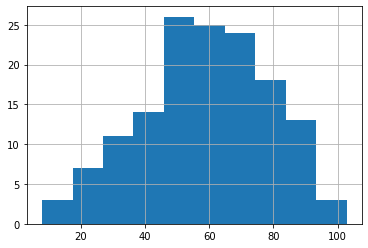

In [15]:
df['all_util'].hist()

In [16]:
df['all_util'].value_counts(1, dropna=False)

NaN     0.999431
58.3    0.000012
63.9    0.000008
74.3    0.000008
50.0    0.000008
          ...   
54.0    0.000004
64.7    0.000004
37.7    0.000004
72.7    0.000004
86.0    0.000004
Name: all_util, Length: 127, dtype: float64

In [17]:
df['all_util'] = (df['all_util'].notnull())*1
df['all_util'].value_counts(1, dropna=False)

0    0.999431
1    0.000569
Name: all_util, dtype: float64

In [18]:
vars_bin.append('all_util')
col_vs_tgt(df, 'all_util')

#### 4.	annual inc: Los ingresos anuales autoinformadas proporcionados por el prestatario durante el registro

In [19]:
df['annual_inc'].isnull().sum()

0

In [20]:
df['annual_inc'].describe([i/10 for i in range(10)])

count    2.529710e+05
mean     7.253825e+04
std      5.881181e+04
min      3.000000e+03
0%       3.000000e+03
10%      3.350000e+04
20%      4.100000e+04
30%      4.803400e+04
40%      5.500000e+04
50%      6.200000e+04
60%      7.000000e+04
70%      8.000000e+04
80%      9.500000e+04
90%      1.200000e+05
max      8.706582e+06
Name: annual_inc, dtype: float64

In [21]:
df['annual_inc'], df_bins['annual_inc'] = pd.qcut(df['annual_inc'], q=5, retbins=True)
vars_cat.append('annual_inc')
col_vs_tgt(df, 'annual_inc')

#### 5.	annual inc joint: Los ingresos anuales autoinformadas combinados proporcionados por los co-prestatarios durante el registro

In [22]:
df['annual_inc_joint'].isnull().mean()

0.9999960469777168

In [23]:
df.drop('annual_inc_joint', axis=1, inplace=True)

#### 6.	collection recovery fee: cargo posterior a la tarifa de cobro.


In [24]:
df['collection_recovery_fee'].isnull().sum()

0

In [25]:
df['collection_recovery_fee'] = (df['collection_recovery_fee']>0)*1
df['collection_recovery_fee'].value_counts(1, dropna=False)

0    0.908942
1    0.091058
Name: collection_recovery_fee, dtype: float64

In [26]:
vars_bin.append('collection_recovery_fee')
col_vs_tgt(df, 'collection_recovery_fee')

#### 7.	collections 12 mths ex med: Número de colecciones en 12 meses, excluidas las colecciones médicas.


In [27]:
df['collections_12_mths_ex_med'].value_counts(1, dropna=False)

0.0    0.993557
1.0    0.005795
2.0    0.000379
NaN    0.000221
3.0    0.000032
4.0    0.000008
5.0    0.000004
6.0    0.000004
Name: collections_12_mths_ex_med, dtype: float64

In [28]:
aux = df.copy()
aux['g'] = (aux['collections_12_mths_ex_med']>0)*1
col_vs_tgt(aux, 'g')

In [29]:
df.drop(columns=['collections_12_mths_ex_med'], inplace=True)

#### 8.	delinq 2yrs: El número de más de 30 días de incidencias vencidas de morosidad en el archivo de crédito del prestatario durante los últimos 2 años.


In [30]:
df['delinq_2yrs'].value_counts(1, dropna=False)

0.0     0.838985
1.0     0.111392
2.0     0.030671
3.0     0.010167
4.0     0.004111
5.0     0.002139
6.0     0.001040
7.0     0.000557
8.0     0.000340
9.0     0.000198
10.0    0.000119
12.0    0.000095
11.0    0.000079
14.0    0.000032
18.0    0.000016
13.0    0.000016
15.0    0.000016
17.0    0.000008
16.0    0.000008
19.0    0.000004
22.0    0.000004
29.0    0.000004
Name: delinq_2yrs, dtype: float64

In [31]:
df['delinq_2yrs'] = (df['delinq_2yrs']>0)*1
df['delinq_2yrs'].value_counts(1, dropna=False)

0    0.838985
1    0.161015
Name: delinq_2yrs, dtype: float64

In [32]:
vars_bin.append('delinq_2yrs')
col_vs_tgt(df, 'delinq_2yrs')

#### 9.	desc: Descripción del préstamo proporcionada por el prestatario.


In [33]:
df['desc'].astype(str).str.split().str[0].value_counts(1, dropna=False).to_frame().head(22)

,desc
nan,0.650873
Borrower,0.321515
I,0.008712
This,0.001135
My,0.000889
NaN,0.000854
I'm,0.000652
The,0.000609
To,0.000502
We,0.000498


In [34]:
df['desc'] = df['desc'].notnull()*1
df['desc'].value_counts(1, dropna=False)

0    0.650873
1    0.349127
Name: desc, dtype: float64

In [35]:
vars_bin.append('desc')
col_vs_tgt(df, 'desc')

#### 10.	dti: Una relación calculada utilizando los pagos mensuales totales de la deuda del prestatario sobre las obligaciones totales de la deuda, excluyendo la hipoteca y el préstamo LC solicitado, dividido por los ingresos mensuales autoinformadas del prestatario


<AxesSubplot:>

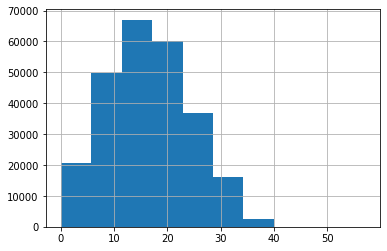

In [36]:
df['dti'].hist()

In [37]:
vars_num.append('dti')

#### 11.	dti joint: Una relación calculada utilizando los pagos mensuales totales de los co-prestatarios sobre las obligaciones totales de deuda, excluyendo las hipotecas y el préstamo LC solicitado, dividido por los ingresos mensuales autoinformadas


In [38]:
df['dti_joint'].value_counts(1, dropna=False)

NaN     0.999996
17.6    0.000004
Name: dti_joint, dtype: float64

In [39]:
df.drop('dti_joint', axis=1, inplace=True)

#### 12.	earliest cr line: El mes en que se abrió la línea de crédito reportada más temprana del prestatario.


In [40]:
df['earliest_cr_line'].value_counts(1, dropna=False)

Oct-2000    0.008349
Oct-1999    0.007768
Oct-2001    0.007740
Nov-2000    0.007610
Aug-2000    0.007598
              ...   
Dec-1950    0.000004
Jan-1959    0.000004
Oct-2012    0.000004
Mar-1965    0.000004
Aug-1960    0.000004
Name: earliest_cr_line, Length: 644, dtype: float64

In [41]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format=r'%b-%Y')
vars_date.append('earliest_cr_line')

#### 13.	emp length: Duración del empleo en años. Los valores posibles están entre 0 y 10, donde 0 significa menos de un año y 10 significa diez o más años.


In [42]:
df['emp_length'].value_counts(0, dropna=False).sort_index()

1 year       16856
10+ years    76881
2 years      23561
3 years      20380
4 years      16197
5 years      18059
6 years      14753
7 years      14085
8 years      11849
9 years       9567
< 1 year     20886
NaN           9897
Name: emp_length, dtype: int64

In [43]:
import numpy as np

df_replace['emp_length'] = {np.nan: '00-02',
                            '< 1 year': '00-02',
                            '1 year': '00-02',
                            '2 years': '00-02',
                            '3 years': '03-05',
                            '4 years': '03-05',
                            '5 years': '03-05',
                            '6 years': '06-08',
                            '7 years': '06-08',
                            '8 years': '06-08',
                            '9 years': '09-99',
                            '10+ years': '09-99'}

df['emp_length'] = df['emp_length'].map(df_replace['emp_length'])
df['emp_length'].value_counts(1, dropna=False)

09-99    0.341731
00-02    0.281455
03-05    0.215977
06-08    0.160837
Name: emp_length, dtype: float64

In [44]:
vars_cat.append('emp_length')
col_vs_tgt(df, 'emp_length')

#### 14.	emp title: El título del trabajo proporcionado por el Prestatario al solicitar el préstamo.*


In [45]:
df['emp_title'].fillna('unknown', inplace=True)
df['emp_title'].value_counts(1, dropna=False)

unknown                                    0.055070
Manager                                    0.007673
Teacher                                    0.007546
Supervisor                                 0.003368
RN                                         0.003324
                                             ...   
Payless Drug                               0.000004
Empress                                    0.000004
California State University Los Angeles    0.000004
SIGMAnet                                   0.000004
Union County                               0.000004
Name: emp_title, Length: 132762, dtype: float64

In [46]:
df['emp_title'], count_v['emp_title'] = replace_top_words(df, 'emp_title', max_features=10, stop_words=['and','of','us','inc','the','city','county','country','group','center'])
df['emp_title'].value_counts(1, dropna=False)

other         0.762874
manager       0.068158
unknown       0.055070
assistant     0.016749
director      0.016678
analyst       0.014421
service       0.014282
specialist    0.013124
supervisor    0.013057
services      0.012958
sales         0.012630
Name: emp_title, dtype: float64

In [47]:
vars_cat.append('emp_title')
col_vs_tgt(df, 'emp_title')

#### 15.	funded amnt: El importe total comprometido para ese préstamo en ese momento.


In [48]:
df['funded_amnt'].isnull().sum()

0

<AxesSubplot:>

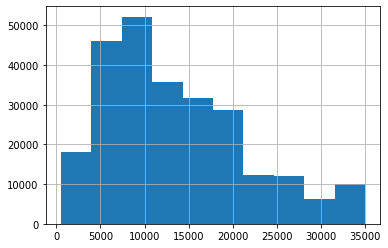

In [49]:
df['funded_amnt'].hist()

In [50]:
vars_num.append('funded_amnt')

#### 16.	funded amnt inv: La cantidad total comprometida por los inversores para ese préstamo en ese momento.


In [51]:
df['funded_amnt_inv'].isnull().sum()

0

In [52]:
df[['funded_amnt_inv','funded_amnt']].corr()

,funded_amnt_inv,funded_amnt
funded_amnt_inv,1.000000,0.994612
funded_amnt,0.994612,1.000000


In [53]:
vars_num.append('funded_amnt_inv')

#### 17.	grade: LC asignó grado de préstamo.


In [54]:
df['grade'].value_counts(1, dropna=False)

B    0.300687
C    0.258211
A    0.167197
D    0.160121
E    0.075843
F    0.030280
G    0.007661
Name: grade, dtype: float64

In [55]:
vars_cat.append('grade')
col_vs_tgt(df, 'grade')

#### 18.	home ownership: El estado de propiedad de la vivienda proporcionado por el prestatario durante el registro. Nuestros valores son: ALQUILER, PROPIO, HIPOTECA, OTRO.


In [56]:
df['home_ownership'].value_counts(1, dropna=False)

MORTGAGE    0.493511
RENT        0.418850
OWN         0.086907
OTHER       0.000557
NONE        0.000170
ANY         0.000004
Name: home_ownership, dtype: float64

In [57]:
df_replace['home_ownership'] = {'MORTGAGE': 'MORTGAGE',
                                'RENT': 'RENT',
                                'OWN': 'OTHER',
                                'OTHER': 'OTHER',
                                'NONE': 'OTHER',
                                'ANY': 'OTHER'}
                                
df['home_ownership'] = df['home_ownership'].map(df_replace['home_ownership'])
df['home_ownership'].value_counts(1, dropna=False)

MORTGAGE    0.493511
RENT        0.418850
OTHER       0.087639
Name: home_ownership, dtype: float64

In [58]:
vars_cat.append('home_ownership')
col_vs_tgt(df, 'home_ownership')

#### 19.	id: Una LC única asignada ID para el listado de préstamos.


In [59]:
df['id'].isnull().sum()

0

#### 20.	il util: Relación entre el saldo corriente total y el límite de crédito/crédito alto en todos los valores de la instalación.


In [60]:
df['il_util'].value_counts(1, dropna=False)

NaN      0.999502
78.7     0.000008
88.3     0.000008
77.6     0.000008
97.5     0.000008
           ...   
96.6     0.000004
87.0     0.000004
101.3    0.000004
74.8     0.000004
99.5     0.000004
Name: il_util, Length: 117, dtype: float64

In [61]:
aux = df.copy()
aux['grouped'] = (df['il_util'].notnull())*1
col_vs_tgt(aux, 'grouped')

In [62]:
df.drop('il_util', axis=1, inplace=True)

#### 21.	initial list status: El estado de listado inicial del préstamo. Los valores posibles son – W, F.


In [63]:
df['initial_list_status'].value_counts(1, dropna=False)

f    0.719762
w    0.280238
Name: initial_list_status, dtype: float64

In [64]:
df_replace['initial_list_status'] = {'f':0, 'w':1}

df['initial_list_status'] = df['initial_list_status'].map(df_replace['initial_list_status'])

vars_bin.append('initial_list_status')
col_vs_tgt(df, 'initial_list_status')

#### 22.	inq fi: Número de consultas de finanzas personales.


In [65]:
df['inq_fi'].value_counts(1, dropna=False)

NaN    0.999431
0.0    0.000245
1.0    0.000186
2.0    0.000047
3.0    0.000028
4.0    0.000020
7.0    0.000016
5.0    0.000016
6.0    0.000008
9.0    0.000004
Name: inq_fi, dtype: float64

In [66]:
aux = df.copy()
aux['grouped'] = (df['inq_fi'].notnull())*1
col_vs_tgt(aux, 'grouped')

In [67]:
df.drop('inq_fi', axis=1, inplace=True)

#### 23.	inq last 12m: Número de consultas de crédito en los últimos 12 meses.


In [68]:
df['inq_last_12m'].value_counts(1, dropna=False)

 NaN     0.999431
 2.0     0.000119
 1.0     0.000099
 0.0     0.000075
 3.0     0.000075
-4.0     0.000055
 6.0     0.000032
 4.0     0.000024
 7.0     0.000024
 10.0    0.000016
 5.0     0.000016
 12.0    0.000012
 8.0     0.000004
 19.0    0.000004
 16.0    0.000004
 13.0    0.000004
 11.0    0.000004
 15.0    0.000004
Name: inq_last_12m, dtype: float64

In [69]:
aux = df.copy()
aux['aux'] = (aux['inq_last_12m'].notnull())*1
col_vs_tgt(aux, 'aux')

In [70]:
df.drop('inq_last_12m', axis=1, inplace=True)

#### 24.	inq last 6mths: El número de consultas en los últimos 6 meses (excluyendo las consultas de automóviles e hipotecas).


In [71]:
df['inq_last_6mths'].value_counts(1, dropna=False)

0.0    0.489234
1.0    0.287523
2.0    0.137439
3.0    0.063482
4.0    0.014595
5.0    0.005431
6.0    0.002044
7.0    0.000182
8.0    0.000071
Name: inq_last_6mths, dtype: float64

In [72]:
df_replace['inq_last_6mths'] = {x:str(x) if x<3 else '>2' for x in range(11)}

df['inq_last_6mths'] = df['inq_last_6mths'].map(df_replace['inq_last_6mths'])
df['inq_last_6mths'].value_counts(1, dropna=False)

0     0.489234
1     0.287523
2     0.137439
>2    0.085804
Name: inq_last_6mths, dtype: float64

In [73]:
vars_cat.append('inq_last_6mths')
col_vs_tgt(df, 'inq_last_6mths')

#### 25.	installment: El pago mensual adeudado por el prestatario si el préstamo se origina.


<AxesSubplot:>

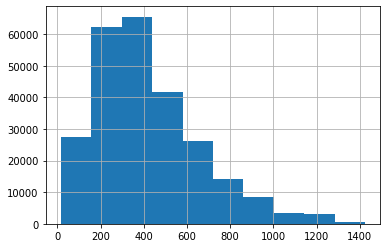

In [74]:
df['installment'].hist()

In [75]:
vars_num.append('installment')

#### 26.	int rate: Tasa de interés del préstamo.


<AxesSubplot:>

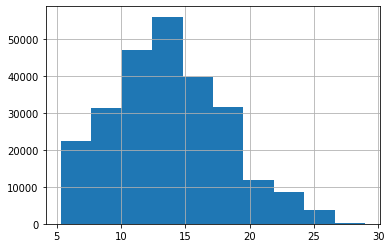

In [76]:
df['int_rate'].hist()

In [77]:
vars_num.append('int_rate')

#### 27.	issue d: El mes en que se financió el préstamo


In [78]:
df['issue_d'].value_counts(1, dropna=False)

Oct-2014    0.034498
Jul-2014    0.033707
Apr-2014    0.026493
Nov-2013    0.026256
Oct-2013    0.026232
              ...   
Aug-2007    0.000130
Sep-2008    0.000126
Jul-2007    0.000119
Sep-2007    0.000071
Jun-2007    0.000004
Name: issue_d, Length: 103, dtype: float64

In [79]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format=r'%b-%Y')
vars_date.append('issue_d')

#### 28.	last credit pull d: El mes más reciente LC sacó crédito para este préstamo.


In [80]:
df['last_credit_pull_d'].value_counts(1, dropna=False)

Jan-2016    0.403418
Dec-2015    0.073087
Nov-2015    0.043226
Oct-2015    0.039277
Sep-2015    0.038336
              ...   
Jul-2008    0.000004
Jun-2008    0.000004
May-2007    0.000004
Jul-2007    0.000004
May-2008    0.000004
Name: last_credit_pull_d, Length: 103, dtype: float64

In [81]:
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format=r'%b-%Y')
vars_date.append('last_credit_pull_d')

#### 29.	last pymnt amnt: Último importe total de pago recibido.


<AxesSubplot:>

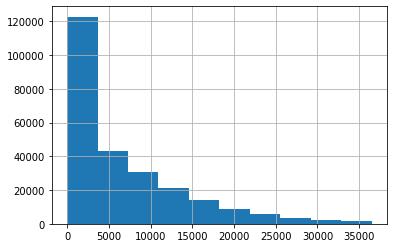

In [82]:
df['last_pymnt_amnt'].hist()

In [83]:
vars_num.append('last_pymnt_amnt')

#### 30.	last pymnt d: El mes pasado se recibió el pago.


In [84]:
df['last_pymnt_d'].value_counts(1, dropna=False)

Jul-2015    0.057208
Oct-2015    0.049425
Dec-2015    0.048065
Aug-2015    0.047480
Jun-2015    0.047341
              ...   
Jun-2008    0.000040
Nov-2008    0.000040
Mar-2008    0.000020
Jan-2008    0.000016
Feb-2008    0.000004
Name: last_pymnt_d, Length: 98, dtype: float64

In [85]:
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format=r'%b-%Y')
vars_date.append('last_pymnt_d')

#### 31.	loan amnt: El monto indicado del préstamo solicitado por el prestatario. Si en algún momento, el departamento de crédito reduce el monto del préstamo, entonces se reflejará en este valor.


<AxesSubplot:>

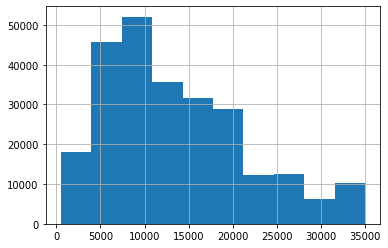

In [86]:
df['loan_amnt'].hist()

In [87]:
vars_num.append('loan_amnt')

#### 32.	loan status: Estado actual del préstamo.


In [88]:
df['loan_status'].value_counts(1, dropna=False)

Fully Paid     0.821134
Charged Off    0.178866
Name: loan_status, dtype: float64

#### 33.	max bal bc: Saldo corriente máximo adeudado en todas las cuentas rotativas.


In [89]:
df['max_bal_bc'].value_counts(1, dropna=False)

NaN        0.999431
0.0        0.000024
2317.0     0.000004
4502.0     0.000004
2760.0     0.000004
             ...   
5705.0     0.000004
5134.0     0.000004
1525.0     0.000004
17177.0    0.000004
10656.0    0.000004
Name: max_bal_bc, Length: 140, dtype: float64

In [90]:
aux = df.copy()
aux['grouped'] = (df['max_bal_bc'].notnull())*1
col_vs_tgt(aux, 'grouped')

In [91]:
df.drop('max_bal_bc', axis=1, inplace=True)

#### 34.	member id: Una LC única asignada id para el miembro prestatario.


In [92]:
len(df) , len(df['member_id'].unique())

(252971, 252971)

#### 35.	mths since last delinq: El número de meses desde la última morosidad del prestatario.


In [93]:
df['mths_since_last_delinq'].value_counts(1, dropna=False)

NaN      0.556665
12.0     0.008112
9.0      0.008096
14.0     0.008048
15.0     0.007981
           ...   
100.0    0.000004
148.0    0.000004
140.0    0.000004
151.0    0.000004
135.0    0.000004
Name: mths_since_last_delinq, Length: 128, dtype: float64

In [94]:
df['mths_since_last_delinq']= (df['mths_since_last_delinq'].notnull())*1
vars_bin.append('mths_since_last_delinq')
col_vs_tgt(df, 'mths_since_last_delinq')

#### 36.	mths since last major derog: Meses desde la calificación más reciente de 90 días o peor.


In [95]:
df['mths_since_last_major_derog'].value_counts(1, dropna=False)

NaN      0.812054
45.0     0.003162
43.0     0.003119
48.0     0.003060
46.0     0.003020
           ...   
141.0    0.000004
145.0    0.000004
139.0    0.000004
136.0    0.000004
129.0    0.000004
Name: mths_since_last_major_derog, Length: 150, dtype: float64

In [96]:
df['mths_since_last_major_derog']= (df['mths_since_last_major_derog'].notnull())*1
vars_bin.append('mths_since_last_major_derog')
col_vs_tgt(df, 'mths_since_last_major_derog')

#### 37.	mths since last record: El número de meses transcurridos desde el último registro público.


In [97]:
df['mths_since_last_record'].value_counts(1, dropna=False)

NaN      0.875092
0.0      0.002660
104.0    0.001866
105.0    0.001858
111.0    0.001846
           ...   
3.0      0.000043
1.0      0.000032
120.0    0.000008
129.0    0.000004
121.0    0.000004
Name: mths_since_last_record, Length: 124, dtype: float64

In [98]:
df['mths_since_last_record']= (df['mths_since_last_record'].notnull())*1
vars_bin.append('mths_since_last_record')
col_vs_tgt(df, 'mths_since_last_record')

#### 38.	mths since rcnt il: Meses desde que se abrieron las cuentas a plazos más recientes.


In [99]:
df['mths_since_rcnt_il'].value_counts(1, dropna=False)

NaN      0.999447
4.0      0.000055
3.0      0.000040
1.0      0.000036
6.0      0.000032
7.0      0.000028
13.0     0.000024
5.0      0.000020
20.0     0.000020
15.0     0.000020
18.0     0.000016
8.0      0.000016
19.0     0.000016
14.0     0.000016
2.0      0.000012
16.0     0.000012
12.0     0.000012
21.0     0.000012
11.0     0.000008
10.0     0.000008
26.0     0.000008
17.0     0.000008
29.0     0.000008
31.0     0.000008
27.0     0.000008
22.0     0.000008
9.0      0.000008
43.0     0.000008
0.0      0.000004
88.0     0.000004
103.0    0.000004
42.0     0.000004
37.0     0.000004
35.0     0.000004
141.0    0.000004
121.0    0.000004
63.0     0.000004
33.0     0.000004
90.0     0.000004
81.0     0.000004
110.0    0.000004
72.0     0.000004
51.0     0.000004
23.0     0.000004
112.0    0.000004
54.0     0.000004
79.0     0.000004
49.0     0.000004
137.0    0.000004
38.0     0.000004
32.0     0.000004
Name: mths_since_rcnt_il, dtype: float64

In [100]:
aux = df.copy()
aux['aux'] = (aux['mths_since_rcnt_il'].notnull())*1
col_vs_tgt(aux, 'aux')

In [101]:
df.drop('mths_since_rcnt_il', axis=1, inplace=True)

#### 39.	next pymnt d: Próxima fecha de pago programada.


In [102]:
df['next_pymnt_d'].value_counts(1, dropna=False)

NaN    1.0
Name: next_pymnt_d, dtype: float64

In [103]:
df.drop('next_pymnt_d', axis=1, inplace=True)

#### 40.	open acc: El número de líneas de crédito abiertas en el archivo de crédito del prestatario.


<AxesSubplot:>

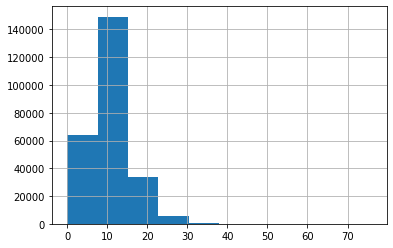

In [104]:
df['open_acc'].hist()

In [105]:
vars_num.append('open_acc')

#### 41.	open acc 6m: Número de operaciones abiertas en los últimos 6 meses


In [106]:
df['open_acc_6m'].value_counts(1, dropna=False)

NaN    0.999431
0.0    0.000182
2.0    0.000150
1.0    0.000142
3.0    0.000055
4.0    0.000020
5.0    0.000012
6.0    0.000008
Name: open_acc_6m, dtype: float64

In [107]:
df['open_acc_6m'] = df['open_acc_6m'].notnull()*1
df['open_acc_6m'].value_counts(1, dropna=False)

0    0.999431
1    0.000569
Name: open_acc_6m, dtype: float64

In [108]:
col_vs_tgt(df, 'open_acc_6m')

In [109]:
df.drop('open_acc_6m', axis=1, inplace=True)

#### 42.	open il 12m: Número de cuentas a plazos abiertas en los últimos 12 meses.


In [110]:
df['open_il_12m'].isnull().mean()

0.9994307647912212

In [111]:
aux = df.copy()
aux['aux'] = (aux['open_il_12m'].notnull())*1
col_vs_tgt(aux, 'aux')

In [112]:
df.drop('open_il_12m', axis=1, inplace=True)

#### 43.	open il 24m: Número de cuentas a plazos abiertas en los últimos 24 meses.


In [113]:
df['open_il_24m'].value_counts(1, dropna=False)

NaN     0.999431
1.0     0.000166
0.0     0.000138
2.0     0.000107
3.0     0.000083
4.0     0.000036
7.0     0.000016
5.0     0.000012
14.0    0.000004
11.0    0.000004
6.0     0.000004
Name: open_il_24m, dtype: float64

In [114]:
aux = df.copy()
aux['aux'] = (aux['open_il_24m'].notnull())*1
col_vs_tgt(aux, 'aux')

In [115]:
df.drop('open_il_24m', axis=1, inplace=True)

#### 44.	open il 6m: Número de operaciones a plazos actualmente activas.


In [116]:
df['open_il_6m'].isnull().mean()

0.9994307647912212

In [117]:
aux = df.copy()
aux['aux'] = (aux['open_il_6m'].notnull())*1
col_vs_tgt(aux, 'aux')

In [118]:
df.drop('open_il_6m', axis=1, inplace=True)

#### 45.	open rv 12m: Número de operaciones rotativas abiertas en los últimos 12 meses.


In [119]:
df['open_rv_12m'].isnull().mean()

0.9994307647912212

In [120]:
aux = df.copy()
aux['aux'] = (aux['open_rv_12m'].notnull())*1
col_vs_tgt(aux, 'aux')

In [121]:
df.drop('open_rv_12m', axis=1, inplace=True)

#### 46.	open rv 24m: Número de operaciones rotativas abiertas en los últimos 24 meses.


In [122]:
df['open_rv_24m'].isnull().mean()

0.9994307647912212

In [123]:
aux = df.copy()
aux['aux'] = (aux['open_rv_24m'].notnull())*1
col_vs_tgt(aux, 'aux')

In [124]:
df.drop('open_rv_24m', axis=1, inplace=True)

#### 47.	out prncp: Capital pendiente restante para el monto total financiado.


In [125]:
df['out_prncp'].value_counts(1, dropna=False)

0.0    1.0
Name: out_prncp, dtype: float64

In [126]:
df.drop('out_prncp', axis=1, inplace=True)

#### 48.	out prncp inv: Capital pendiente restante por parte del importe total financiado por los inversores.


In [127]:
df['out_prncp_inv'].value_counts(1, dropna=False)

0.0    1.0
Name: out_prncp_inv, dtype: float64

In [128]:
df.drop('out_prncp_inv', axis=1, inplace=True)

#### 49.	policy code: disponible públicamente policy code=1 nuevos productos no disponibles públicamente policy code=2.


In [129]:
df['policy_code'].value_counts(1, dropna=False)

1.0    1.0
Name: policy_code, dtype: float64

In [130]:
df.drop('policy_code', axis=1, inplace=True)

#### 50.	pub rec: Número de registros públicos despectivos.


In [131]:
df['pub_rec'].value_counts(1, dropna=False)

0.0     0.877741
1.0     0.108044
2.0     0.010068
3.0     0.002672
4.0     0.000799
5.0     0.000364
6.0     0.000154
7.0     0.000075
8.0     0.000032
9.0     0.000020
10.0    0.000020
11.0    0.000004
15.0    0.000004
12.0    0.000004
Name: pub_rec, dtype: float64

In [132]:
df['pub_rec'] = (df['pub_rec']>0)*1
df['pub_rec'].value_counts(1, dropna=False)

0    0.877741
1    0.122259
Name: pub_rec, dtype: float64

In [133]:
vars_bin.append('pub_rec')
col_vs_tgt(df, 'pub_rec')

#### 51.	purpose: Una categoría proporcionada por el prestatario para la solicitud de préstamo.


In [134]:
df['purpose'].value_counts(1, dropna=False)

debt_consolidation    0.586482
credit_card           0.197952
home_improvement      0.059015
other                 0.056437
major_purchase        0.024766
small_business        0.018761
car                   0.014413
medical               0.011282
moving                0.008017
wedding               0.007728
house                 0.006530
vacation              0.006277
educational           0.001285
renewable_energy      0.001055
Name: purpose, dtype: float64

In [135]:
df['purpose'] = group_lowfreq(df['purpose'], p=0.022)
df['purpose'].value_counts(1, dropna=False)

debt_consolidation    0.586482
credit_card           0.197952
other                 0.131786
home_improvement      0.059015
major_purchase        0.024766
Name: purpose, dtype: float64

In [136]:
vars_cat.append('purpose')
col_vs_tgt(df, 'purpose')

#### 52.	pymnt plan: Indica si se ha establecido un plan de pago para el préstamo.


In [137]:
df['pymnt_plan'].value_counts(1, dropna=False)

n    0.999992
y    0.000008
Name: pymnt_plan, dtype: float64

In [138]:
df.drop('pymnt_plan', axis=1, inplace=True)

#### 53.	recoveries: cargo posterior a la recuperación bruta.


In [139]:
df['recoveries'].value_counts(1, dropna=False)

0.00       0.904388
200.00     0.000040
11.70      0.000036
14.28      0.000036
10.40      0.000032
             ...   
2350.08    0.000004
136.41     0.000004
280.05     0.000004
253.27     0.000004
339.26     0.000004
Name: recoveries, Length: 22627, dtype: float64

In [140]:
df['recoveries'] = (df['recoveries']>0)*1
df['recoveries'].value_counts(1, dropna=False)

0    0.904388
1    0.095612
Name: recoveries, dtype: float64

In [141]:
vars_bin.append('recoveries')
col_vs_tgt(df, 'recoveries')

#### 54.	revol bal: Saldo rotatorio de crédito total.


In [142]:
df['revol_bal'].describe([i/10 for i in range(10)])

count    2.529710e+05
mean     1.516798e+04
std      1.874300e+04
min      0.000000e+00
0%       0.000000e+00
10%      2.914000e+03
20%      4.947000e+03
30%      6.789000e+03
40%      8.746000e+03
50%      1.093700e+04
60%      1.354300e+04
70%      1.691500e+04
80%      2.175600e+04
90%      3.037000e+04
max      1.746716e+06
Name: revol_bal, dtype: float64

In [143]:
df['revol_bal'], df_bins['revol_bal'] = pd.qcut(df['revol_bal'], q=5, retbins=True)
vars_cat.append('revol_bal')
col_vs_tgt(df, 'revol_bal')

#### 55.	revol util: Tasa de utilización de la línea rotativa, o la cantidad de crédito que el prestatario está utilizando en relación con todo el crédito rotatorio disponible.


In [144]:
df['revol_util'].isnull().mean()

0.0007866514343541354

In [145]:
df.dropna(subset=['revol_util'], inplace=True)
df['revol_util'].describe([i/10 for i in range(10)])

count    252772.000000
mean         54.312093
std          24.790577
min           0.000000
0%            0.000000
10%          19.200000
20%          31.500000
30%          40.600000
40%          48.500000
50%          55.800000
60%          62.900000
70%          70.100000
80%          77.800000
90%          86.800000
max         892.300000
Name: revol_util, dtype: float64

In [146]:
df['revol_util'], df_bins['revol_util'] = pd.qcut(df['revol_util'], q=5, retbins=True)
vars_cat.append('revol_util')
col_vs_tgt(df, 'revol_util')

#### 56.	sub grade: Subsuelo de préstamo asignado LC.


In [147]:
df[['grade','sub_grade']].value_counts().to_frame().sort_index()

0
grade sub_grade       
A     A1          5868
      A2          6202
      A3          7171
      A4         11054
      A5         11991
B     B1         12093
      B2         14624
      B3         18062
      B4         16922
      B5         14339
C     C1         14949
      C2         14326
      C3         12769
      C4         12044
      C5         11179
D     D1         10030
      D2          9035
      D3          7981
      D4          7374
      D5          6026
E     E1          4702
      E2          4522
      E3          3790
      E4          3326
      E5          2814
F     F1          2227
      F2          1741
      F3          1531
      F4          1189
      F5           959
G     G1           687
      G2           496
      G3           330
      G4           233
      G5           186

In [148]:
vars_cat.append('sub_grade')
col_vs_tgt(df, 'sub_grade')

#### 57.	term: El número de pagos del préstamo. Los valores están en meses y pueden ser 36 o 60.


In [149]:
df['term'].value_counts(1, dropna=False)

 36 months    0.777365
 60 months    0.222635
Name: term, dtype: float64

In [150]:
df_replace['term'] = {' 36 months':0, ' 60 months':1}
df['term'] = df['term'].map(df_replace['term'])
df['term'].value_counts(1, dropna=False)

0    0.777365
1    0.222635
Name: term, dtype: float64

In [151]:
vars_bin.append('term')
col_vs_tgt(df, 'term')

#### 58.	title: El título del préstamo proporcionado por el prestatario.


In [152]:
df['title'].value_counts(1, dropna=False)

Debt consolidation         0.284992
Credit card refinancing    0.090144
Debt Consolidation         0.043858
Home improvement           0.026641
Other                      0.023836
                             ...   
Trust1                     0.000004
Debt cos                   0.000004
dream house                0.000004
1st loan cc                0.000004
Dbet Consolidation         0.000004
Name: title, Length: 47873, dtype: float64

In [153]:
df['title'].fillna('unknown', inplace=True)
df['title'], count_v['title'] = replace_top_words(df, 'title', max_features=10, stop_words=['and','of','us','the','to'])
df['title'].value_counts(1, dropna=False)

consolidation    0.416648
other            0.236696
card             0.149997
loan             0.064347
home             0.050342
debt             0.049432
credit           0.022827
payoff           0.008272
improvement      0.000882
refinancing      0.000558
Name: title, dtype: float64

In [154]:
df_replace['title'] = {'consolidation': 'consolidation',
                        'other': 'other',
                        'card': 'credit',
                        'loan': 'loan',
                        'home': 'home',
                        'debt': 'consolidation',
                        'credit': 'credit',
                        'payoff': 'consolidation',
                        'improvement': 'home',
                        'refinancing': 'loan'}
df['title'] = df['title'].map(df_replace['title'])
df['title'].value_counts(1, dropna=False)

consolidation    0.474352
other            0.236696
credit           0.172824
loan             0.064904
home             0.051224
Name: title, dtype: float64

In [155]:
vars_cat.append('title')
col_vs_tgt(df, 'title')

#### 59.	tot coll amt: Montos totales de cobro adeudados.


In [156]:
df['tot_coll_amt'].value_counts(1, dropna=False)

0.0        0.662443
NaN        0.251725
50.0       0.001381
100.0      0.001199
75.0       0.000934
             ...   
1981.0     0.000004
10604.0    0.000004
1709.0     0.000004
2675.0     0.000004
1674.0     0.000004
Name: tot_coll_amt, Length: 4029, dtype: float64

In [157]:
import numpy as np

df_replace['tot_coll_amt'] = {np.nan:'unknown', 0:'00'}
df['tot_coll_amt'] = df['tot_coll_amt'].map(df_replace['tot_coll_amt']).fillna('>0')
df['tot_coll_amt'].value_counts(1, dropna=False)

00         0.662443
unknown    0.251725
>0         0.085832
Name: tot_coll_amt, dtype: float64

In [158]:
vars_cat.append('tot_coll_amt')
col_vs_tgt(df, 'tot_coll_amt')

#### 60.	tot cur bal: Saldo corriente total de todas las cuentas.


In [159]:
df['tot_cur_bal'].value_counts(1, dropna=False)

NaN         0.251725
0.0         0.000166
19376.0     0.000036
28674.0     0.000036
25341.0     0.000036
              ...   
204299.0    0.000004
8041.0      0.000004
269868.0    0.000004
50045.0     0.000004
12547.0     0.000004
Name: tot_cur_bal, Length: 134673, dtype: float64

In [160]:
df['tot_cur_bal'] = (df['tot_cur_bal'].notnull())*1
vars_bin.append('tot_cur_bal')
col_vs_tgt(df, 'tot_cur_bal')

#### 61.	total bal il: Saldo actual total de todas las cuentas a plazos.


In [161]:
df['total_bal_il'].value_counts(1, dropna=False)

NaN        0.999430
0.0        0.000067
42905.0    0.000004
31510.0    0.000004
9769.0     0.000004
             ...   
14149.0    0.000004
17946.0    0.000004
73207.0    0.000004
19836.0    0.000004
7218.0     0.000004
Name: total_bal_il, Length: 129, dtype: float64

In [162]:
aux = df.copy()
aux['aux'] = (aux['total_bal_il'].notnull())*1
col_vs_tgt(aux, 'aux')

In [163]:
df.drop('total_bal_il', axis=1, inplace=True)

#### 62.	total cu tl: Número de operaciones financieras.


In [164]:
df['total_cu_tl'].value_counts(1, dropna=False)

NaN     0.999430
0.0     0.000309
1.0     0.000067
2.0     0.000063
3.0     0.000032
4.0     0.000020
7.0     0.000012
12.0    0.000012
8.0     0.000008
5.0     0.000008
6.0     0.000008
9.0     0.000004
10.0    0.000004
15.0    0.000004
13.0    0.000004
18.0    0.000004
17.0    0.000004
11.0    0.000004
21.0    0.000004
Name: total_cu_tl, dtype: float64

In [165]:
aux = df.copy()
aux['aux'] = (aux['total_cu_tl'].notnull())*1
col_vs_tgt(aux, 'aux')

In [166]:
df.drop('total_cu_tl', axis=1, inplace=True)

#### 63.	total pymnt: Pagos recibidos hasta la fecha por el importe total financiado.


<AxesSubplot:>

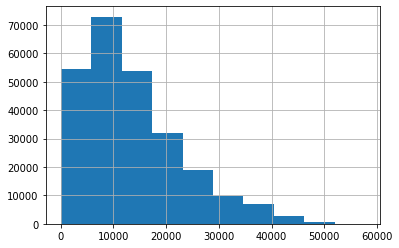

In [167]:
df['total_pymnt'].hist()

In [168]:
vars_num.append('total_pymnt')

#### 64.	total pymnt inv: Pagos recibidos hasta la fecha por una parte del importe total financiado por los inversores.


<AxesSubplot:>

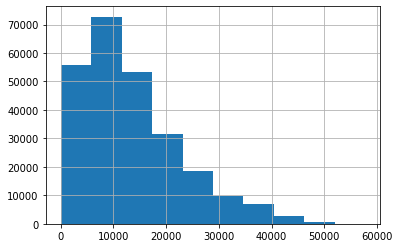

In [169]:
df['total_pymnt_inv'].hist()

In [170]:
df[['total_pymnt_inv','total_pymnt']].corr()

,total_pymnt_inv,total_pymnt
total_pymnt_inv,1.000000,0.995737
total_pymnt,0.995737,1.000000


In [171]:
vars_num.append('total_pymnt_inv')

#### 65.	total rec int: Intereses recibidos hasta la fecha.


<AxesSubplot:>

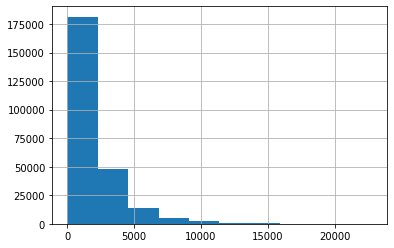

In [172]:
df['total_rec_int'].hist()

In [173]:
df['total_rec_int'].describe()

count    252772.000000
mean       1947.117125
std        2065.767080
min           0.000000
25%         629.747500
50%        1310.575000
75%        2486.650000
max       22777.580000
Name: total_rec_int, dtype: float64

In [174]:
df['total_rec_int'], df_bins['total_rec_int'] = pd.qcut(df['total_rec_int'], q=5, retbins=True)
vars_cat.append('total_rec_int')
col_vs_tgt(df, 'total_rec_int')

#### 66.	total rec prncp: Principal recibido hasta la fecha.


<AxesSubplot:>

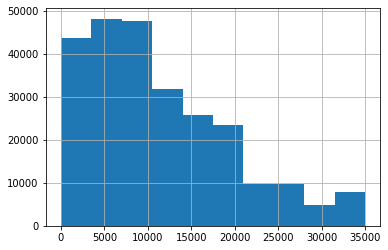

In [175]:
df['total_rec_prncp'].hist()

In [176]:
vars_num.append('total_rec_prncp')

#### 67.	total rev hi lim: Límite de crédito/crédito revolving total alto.


In [177]:
df['total_rev_hi_lim'].isnull().mean()

0.2517248745905401

In [178]:
df['total_rev_hi_lim'].describe([i/10 for i in range(10)])

count    1.891430e+05
mean     2.971858e+04
std      2.950545e+04
min      1.000000e+02
0%       1.000000e+02
10%      8.200000e+03
20%      1.170000e+04
30%      1.490000e+04
40%      1.840000e+04
50%      2.230000e+04
60%      2.700000e+04
70%      3.300000e+04
80%      4.160000e+04
90%      5.740000e+04
max      2.013133e+06
Name: total_rev_hi_lim, dtype: float64

In [179]:
df['total_rev_hi_lim'], df_bins['total_rev_hi_lim'] = pd.qcut(df['total_rev_hi_lim'], q=5, retbins=True)
vars_cat.append('total_rev_hi_lim')
col_vs_tgt(df, 'total_rev_hi_lim')

#### 68.	url: Dirección URL de la página lc con datos de listado.


In [180]:
df['url'].str.split('/').str[-1].str.split('=').str[-1].value_counts(dropna=False)

845130      1
584657      1
1111232     1
3694667     1
28734416    1
           ..
504692      1
39760370    1
50829376    1
44985994    1
43540041    1
Name: url, Length: 252772, dtype: int64

#### 69.	verification status: Indica si lc verificó los ingresos, no los verificó o si se verificó la fuente de ingresos.


In [181]:
df['verification_status'].value_counts(1, dropna=False)

Verified           0.367212
Not Verified       0.340220
Source Verified    0.292568
Name: verification_status, dtype: float64

In [182]:
vars_cat.append('verification_status')

#### 70.	verified status joint: Indica si los ingresos conjuntos de los co-prestatariosMfueron verificados por LC, no verificados, o si la fuente de ingresos fue verificada.


In [183]:
df['verification_status_joint'].value_counts(1, dropna=False)

NaN                0.999996
Source Verified    0.000004
Name: verification_status_joint, dtype: float64

In [184]:
df.drop('verification_status_joint', axis=1, inplace=True)

#### 71.	zip code: Los primeros 3 números del código postal proporcionado por el prestatario en la solicitud de préstamo

In [185]:
df['zip_code'].value_counts(1, dropna=False).to_frame().sort_index()

,zip_code
007xx,0.000008
008xx,0.000004
010xx,0.001689
011xx,0.000419
012xx,0.000352
...,...
995xx,0.001373
996xx,0.000506
997xx,0.000427
998xx,0.000206


In [186]:
df['zip_code'] = df['zip_code'].str[:1].str.zfill(2)
df['zip_code'].value_counts(1, dropna=False)

09    0.215514
03    0.124816
01    0.120045
07    0.103481
02    0.101471
00    0.087435
08    0.077445
04    0.074367
06    0.060517
05    0.034909
Name: zip_code, dtype: float64

In [187]:
vars_cat.append('zip_code')
col_vs_tgt(df, 'zip_code')

## Ingeniería de variables

In [188]:
# df.to_csv(BASE_DIR.joinpath(f'checkpoint_{FILE_NAME}'), index=False)

import pandas as pd
from pathlib import Path
BASE_DIR = Path(BASE_DIR)
df = pd.read_csv(BASE_DIR.joinpath(f'checkpoint_{FILE_NAME}'), low_memory=False)

In [190]:
df[vars_date+vars_bin+vars_cat+vars_num].sample()

,earliest_cr_line,issue_d,last_credit_pull_d,last_pymnt_d,acc_now_delinq,all_util,collection_recovery_fee,delinq_2yrs,desc,initial_list_status,...,funded_amnt,funded_amnt_inv,installment,int_rate,last_pymnt_amnt,loan_amnt,open_acc,total_pymnt,total_pymnt_inv,total_rec_prncp
197329,2001-08-01,2012-09-01,2013-05-01,2013-05-01,0,0,0,0,0,0,...,8875.0,8875.0,291.15,11.14,7443.17,8875.0,7.0,9479.83,9479.83,8875.0


## Modelo

### Pre-procesamiento

In [194]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1].copy()
y = df.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    train_size=0.77,
                                                    random_state=22)
mm_x = MinMaxScaler()

### Arquitectura

In [195]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()

model_reg = Pipeline(steps=[('scaler', mm_x),
                            ('model', linear_reg)])

print(f"Score: {'{:.2%}'.format(model_reg.fit(X_train,y_train).score(X_test,y_test))}")
print(f"Training score: {'{:.2%}'.format(model_reg.score(X_train,y_train))}")
print("\nThese are the most influential variables:")
coef = pd.DataFrame(zip(X.columns,model_reg[1].coef_)).sort_values(1,0,0).reset_index(drop=True)
coef.head().append(coef.tail())

Score: 67.39%
Training score: 67.11%

These are the most influential variables:


,0,1
0,funded_amnt,1.703470
1,total_pymnt_inv,0.379810
2,installment,0.210918
3,loan_amnt,0.121097
4,int_rate,0.095894
6,open_acc,-0.054354
7,last_pymnt_amnt,-0.095962
8,funded_amnt_inv,-0.249948
9,total_pymnt,-0.297873
10,total_rec_prncp,-2.071609


## Predicción

In [ ]:
import numpy as np
val['2018_26'] = np.clip(model_reg.predict(val), 0, 1e10).round()
val.head()

In [ ]:
val[['2018_26']].to_csv(BASE_DIR.joinpath(f"Bren_{VALID_NAME_SUB}_final.csv"))